In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import re

# Load the dataset
data = pd.read_csv('/content/AI dataset-Email.csv')

# Preprocessing (you can add more preprocessing steps as needed)
# Here, we'll convert text to lowercase and remove punctuation
data['Processed Text'] = data['Email Body'].str.lower().replace('[^\w\s]', '', regex=True)

# Rule-based classification
rules = {
    'Account-related': ['account', 'statement', 'balance', 'transaction', 'address', 'change'],
    'Fraud': ['suspicious', 'phishing', 'unauthorized', 'scam', 'fraudulent', 'theft'],
    'Loan Application': ['loan', 'mortgage', 'credit', 'payment', 'repayment', 'approval'],
    'General Inquiry': ['inquiry', 'question', 'feedback', 'assistance', 'advice'],
    'Credit Card Statement':['credit card statement','credit','card', 'payment', 'transaction', 'balance', 'late fee', 'interest rate', 'credit limit', 'annual fee', 'reward points', 'foreign transaction', 'minimum payment', 'billing cycle', 'statement date', 'transaction history', 'fraudulent transaction', 'credit score', 'statement delivery', 'format preference', 'notification preference', 'PIN change', 'activation', 'upgrade', 'replacement', 'statement copy', 'transaction authorization', 'payment confirmation', 'balance inquiry', 'summary', 'reconciliation', 'posting confirmation', 'conversion rate']
}

def classify_email(email):
    for category, keywords in rules.items():
        for keyword in keywords:
            if keyword in email.lower():
                return category
    return 'Other'

data['Predicted Category_Rule'] = data['Email Body'].apply(classify_email)

# Feature extraction (TF-IDF vectorization)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Processed Text'])
y = data['Predicted Category_Rule']  # Use rule-based predictions as labels for training

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

# Predict using SVM classifier
predicted_svm = svm_classifier.predict(X_test)

# Check accuracy of SVM predictions
accuracy_svm = accuracy_score(y_test, predicted_svm)
print(f'SVM Classifier Accuracy: {accuracy_svm:.2%}')

# Apply rule-based classification on remaining data (not used for training)
data['Predicted Category_SVM'] = svm_classifier.predict(vectorizer.transform(data['Processed Text']))

# Combine predictions
def combine_predictions(row):
    if row['Predicted Category_Rule'] == row['Predicted Category_SVM']:
        return row['Predicted Category_Rule']
    else:
        return 'Undecided'

data['Combined Prediction'] = data.apply(combine_predictions, axis=1)

# Check accuracy of combined predictions
accuracy_combined = (data['Category'] == data['Combined Prediction']).mean()


SVM Classifier Accuracy: 97.89%


In [ ]:
import re

# Get input from the user
user_input = input("Enter the email content to classify: ")

# Preprocess the input text
processed_input = re.sub(r'[^\w\s]', '', user_input.lower())

# Transform the preprocessed text using TF-IDF vectorizer
input_vector = vectorizer.transform([processed_input])

# Use the trained SVM classifier to predict the category
predicted_category = svm_classifier.predict(input_vector)[0]

# Display the predicted category
print(f"The predicted category for the input email is: {predicted_category}")


Enter the email content to classify: I want to enquire about the Account which i recently terminated
The predicted category for the input email is: Account-related


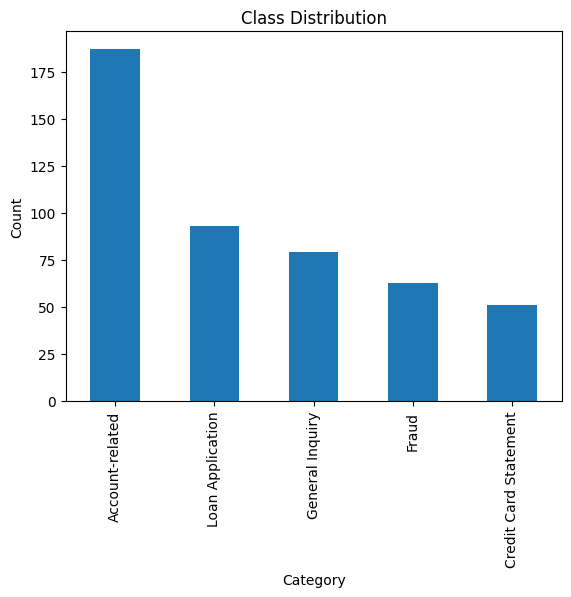

In [ ]:
import matplotlib.pyplot as plt

data['Category'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


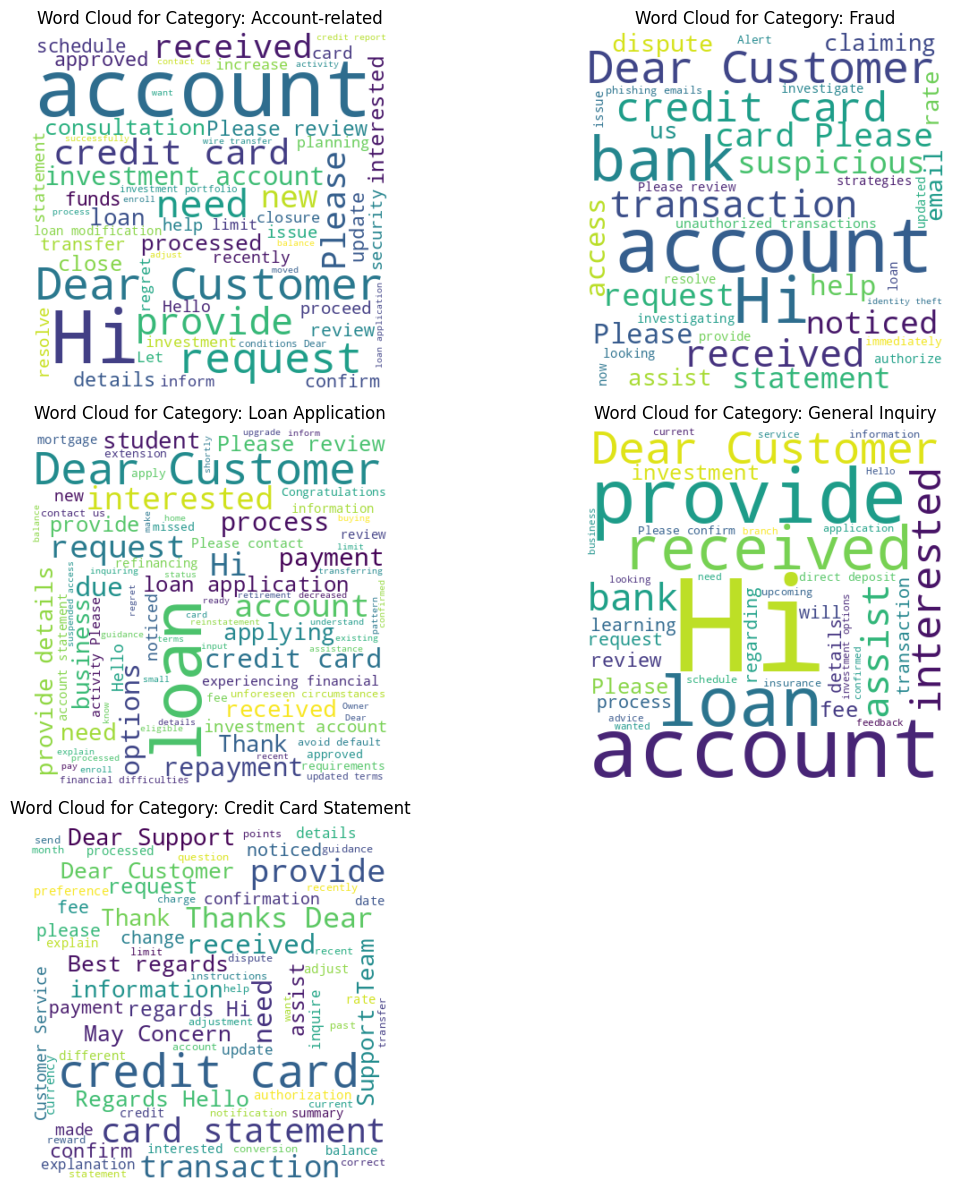

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique categories
categories = data['Category'].unique()

# Determine the layout of subplots based on the number of unique categories
num_categories = len(categories)
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols

# Create a new figure
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over unique categories
for i, category in enumerate(categories):
    # Filter data by category
    category_data = data[data['Category'] == category]

    # Concatenate all email bodies in the category
    text = ' '.join(category_data['Email Body'])

    # Check if there are words available for generating the word cloud
    if len(text) > 0:
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=400, background_color='white', min_font_size=10).generate(text)

        # Plot word cloud in the appropriate subplot
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].set_title(f'Word Cloud for Category: {category}')
        axs[i].axis('off')
    else:
        # Hide the subplot if there are no words available
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()



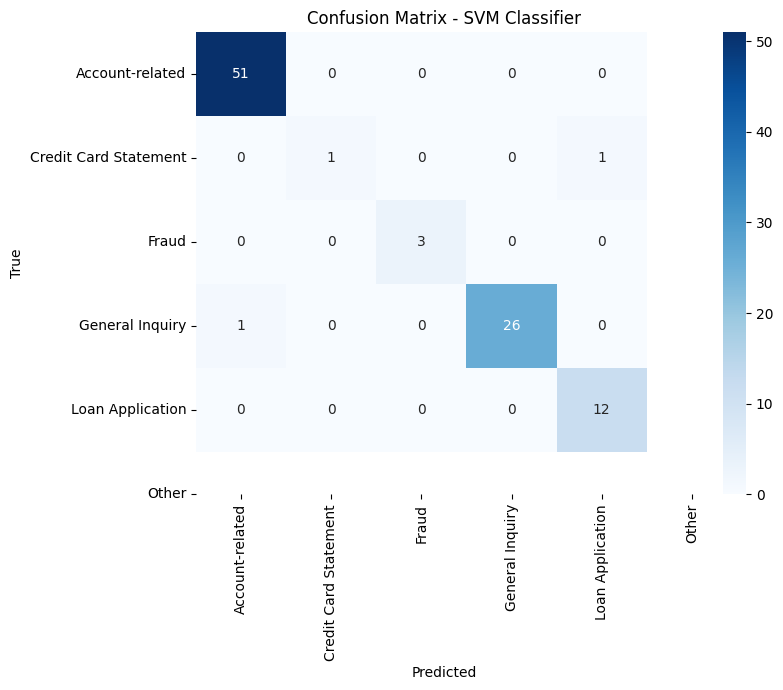

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions using SVM classifier
predicted_svm = svm_classifier.predict(X_test)

# Create confusion matrix
conf_matrix_svm = confusion_matrix(y_test, predicted_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
